In [53]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import brentq
from math import log, sqrt, exp

import seaborn as sns
sns.set_style('darkgrid')

# SABR Model Simulation
So far, we’ve set up and simulated the **SABR model** under the **risk-neutral forward measure**.

The forward rate evolves as  
$$
dF_t = \alpha_t\,F_t^{\beta}\,dW_t,
$$
and the volatility evolves as  
$$
d\alpha_t = \nu\,\alpha_t\,dZ_t,
$$
with correlation  
$$
\rho = \mathrm{Corr}(dW_t,\,dZ_t).
$$

Here,  
- $\beta$ controls the elasticity of the forward,  
- $\nu$ is the volatility-of-volatility parameter, and  
- $\rho$ governs the correlation between the forward and volatility shocks.


[sanity] mean(F_T)=5.0010%, std(F_T)=1.2468%, min/max F_T=(0.8824%, 10.2353%), mean sigma_T=5.59%


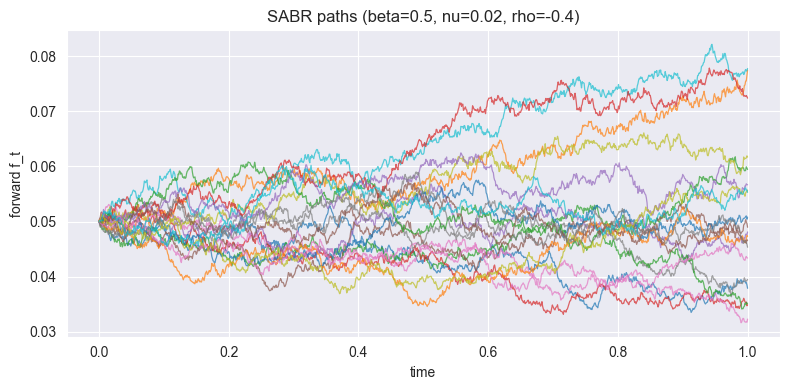

In [49]:
# ===== SABR setup  =====
t = 1.0
f0 = 0.05
n_steps = 1000
n_sims = 10000

beta = 0.5
rho = -0.4
nu = 0.02
alpha = 0.25 * (f0 ** (1 - beta))

# ===== time grid and RNG =====
dt = t / n_steps
time = np.linspace(0, t, n_steps + 1)
rng = np.random.default_rng(45)

# ===== correlated normals for all sims/steps =====
mean = [0.0, 0.0]
cov = [[1.0, rho], [rho, 1.0]]
Z = rng.multivariate_normal(mean, cov, size=(n_sims, n_steps))
Z1 = Z[:, :, 0]
Z2 = Z[:, :, 1]

# ===== exact lognormal sigma path (SABR vol) =====
drift = (-0.5 * nu**2) * dt
log_sigma_increments = drift + nu * np.sqrt(dt) * Z1
log_sigma = np.log(alpha) + np.cumsum(log_sigma_increments, axis=1)
sigma = np.exp(log_sigma)

# ===== forward paths absorbing at 0 =====
f = np.empty((n_sims, n_steps + 1))
f[:, 0] = f0

pow_beta = np.power
sqrt_dt = np.sqrt(dt)

for i in range(n_steps):
    dW = sqrt_dt * Z2[:, i]
    fi = np.maximum(f[:, i], 0.0)
    f[:, i + 1] = f[:, i] + pow_beta(fi, beta) * sigma[:, i] * dW
    f[:, i + 1] = np.maximum(f[:, i + 1], 0.0)

# ===== quick sanity ping =====
F_T = f[:, -1]
print(f"[sanity] mean(F_T)={F_T.mean():.4%}, std(F_T)={F_T.std():.4%}, "
      f"min/max F_T=({F_T.min():.4%}, {F_T.max():.4%}), "
      f"mean sigma_T={sigma[:, -1].mean():.2%}")

# ===== plot a small subset of paths =====
plt.figure(figsize=(8, 4))
for j in range(20):
    plt.plot(time, f[j, :], linewidth=0.9, alpha=0.7)
plt.title(f"SABR paths (beta={beta}, nu={nu}, rho={rho})")
plt.xlabel("time")
plt.ylabel("forward f_t")
plt.tight_layout()
plt.show()


# Caplet Pricing from SABR Paths — Monte Carlo

We now price a **caplet** using the simulated forward paths $F_t$ under the **risk-neutral forward measure**.

- **Underlying:** forward rate $F_t$ for the accrual period $[T_1, T_2]$  
- **Payoff at payment date $T_2$:**
  $$
  \tau\,\max(F_{T_1} - K,\,0)
  $$
- **Present value at time 0:**
  $$
  \text{Caplet}_0
  = P(0,T_2)\;
    \mathbb{E}\!\left[
      \tau\,\max(F_{T_1}-K,0)
    \right]
  $$

In this setup we set $T_1 = t$ (the horizon of our SABR simulation), specify the strike $K$, accrual period $\tau$, and discount factor $P(0,T_2)$.  
The expectation is estimated numerically as the average of the simulated payoffs across all Monte Carlo paths.


Caplet MC price: 0.001239
MC standard error: 0.000019
Inputs: K=0.0500, tau=0.2500, T1=1.0000, T2=1.2500, r=0.0000%, P(0,T2)=1.000000


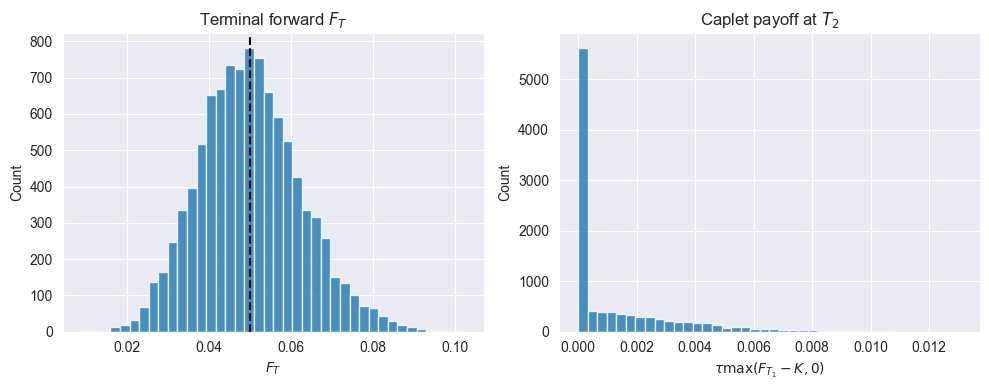

In [50]:
# ----- Caplet inputs -----
K = 0.05
tau = 0.25
T1 = t
T2 = T1 + tau
r = 0.00
P0T2 = np.exp(-r * T2)

# ----- compute MC price -----
iT = int(np.argmin(np.abs(time - T1)))
F_T = f[:, iT]
payoffs = tau * np.maximum(F_T - K, 0.0)
price_mc = P0T2 * payoffs.mean()
stderr = P0T2 * payoffs.std(ddof=1) / np.sqrt(len(payoffs))

print(f"Caplet MC price: {price_mc:.6f}")
print(f"MC standard error: {stderr:.6f}")
print(f"Inputs: K={K:.4f}, tau={tau:.4f}, T1={T1:.4f}, T2={T2:.4f}, r={r:.4%}, P(0,T2)={P0T2:.6f}")

# plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(F_T, bins=40, alpha=0.8)
ax[0].axvline(K, linestyle='--', c='black')
ax[0].set_title("Terminal forward $F_T$")
ax[0].set_xlabel("$F_T$")
ax[0].set_ylabel("Count")

ax[1].hist(payoffs, bins=40, alpha=0.8)
ax[1].set_title("Caplet payoff at $T_2$")
ax[1].set_xlabel(r"$\tau \max(F_{T_1}-K,0)$")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### Black-76 Model — Benchmarking the SABR Caplet

Now that we’ve priced a caplet using Monte Carlo simulation under the **SABR model**, we can benchmark those prices against the classic **Black-76 model**, which is the market standard for quoting interest-rate option prices and implied volatilities.

The **Black-76 model** assumes that the forward rate $F_t$ follows a *lognormal* diffusion with constant volatility $\sigma_{\text{Black}}$ under the risk-neutral forward measure:

$$
dF_t = \sigma_{\text{Black}}\,F_t\,dW_t
$$

For a caplet with forward $F_0$, strike $K$, expiry $T$, discount factor $P(0,T_2)$, and accrual period $\tau$, the **Black-76 price** is

$$
\text{Caplet}_{\text{Black}}
= P(0,T_2)\,\tau\,[\,F_0\,\Phi(d_1) - K\,\Phi(d_2)\,],
$$

where

$$
d_{1,2}
= \frac{\ln(F_0/K) \pm \tfrac12\sigma_{\text{Black}}^{2}T}
        {\sigma_{\text{Black}}\sqrt{T}},
\qquad
\Phi(\cdot)\text{ is the standard normal CDF.}
$$

This closed form gives a benchmark for option prices and lets us compute the **implied volatility** corresponding to any observed (or simulated) price.

In this section we  
1. compute **Monte Carlo SABR caplet prices** across strikes,  
2. invert the **Black-76 formula** to extract **implied vols**, and  
3. plot the resulting **volatility smile** implied by the SABR dynamics.

---

### Hagan et al. (2002) SABR Approximation

While the full SABR model describes both the forward rate and its stochastic volatility,  
Hagan et al. (2002) derived an explicit asymptotic formula for the **Black-implied volatility**
$\sigma_{\text{SABR}}(F,K)$
as a function of the forward $F$, strike $K$, time to expiry $T$,
and model parameters $(\alpha,\nu,\beta,\rho)$:

$$
\sigma_{\text{SABR}}(F,K)
\approx
\frac{\alpha}{(F K)^{\frac{1-\beta}{2}}}
\frac{z}{x(z)}
\!\left[
1 + T
\left(
\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(F K)^{1-\beta}}
+ \frac{\rho\,\beta\,\nu\,\alpha}{4 (F K)^{\frac{1-\beta}{2}}}
+ \frac{(2 - 3\rho^2)\nu^2}{24}
\right)
\right],
$$

with

$$
z = \frac{\nu}{\alpha}(F K)^{\frac{1-\beta}{2}}\ln\!\frac{F}{K},
\qquad
x(z) = \ln\!\left(
\frac{\sqrt{1 - 2\rho z + z^2} + z - \rho}{1 - \rho}
\right).
$$

This converts SABR parameters directly into **Black-style implied volatilities**, allowing us to plot the **analytic SABR smile** (Hagan formula) alongside the **Monte Carlo-implied smile** from our simulated paths.


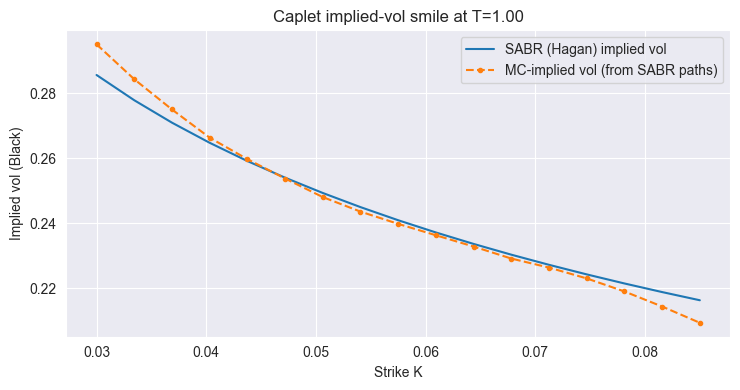

ATM approx (K≈F0):
  MC-implied vol:   0.2480
  SABR/Hagan vol:   0.2493


In [ ]:

# ---------- Black-76 caplet price (lognormal) ----------
def black_caplet(P_Tpay, F, K, sigma, T, tau):
    if sigma <= 0 or T <= 0:
        return P_Tpay * tau * max(F - K, 0.0)
    v = sigma * sqrt(T)
    d1 = (log(F / K) + 0.5 * v * v) / v
    d2 = d1 - v
    return P_Tpay * tau * (F * norm.cdf(d1) - K * norm.cdf(d2))

# ---------- Invert Black to implied vol ----------
def implied_vol_black_caplet(price, P_Tpay, F, K, T, tau):
    intrinsic = P_Tpay * tau * max(F - K, 0.0)
    if price <= intrinsic + 1e-14:
        return 0.0
    f = lambda s: black_caplet(P_Tpay, F, K, s, T, tau) - price
    return brentq(f, 1e-6, 3.0)

# ---------- Hagan SABR lognormal implied vol ----------
def hagan_sabr_iv(F, K, T, nu, beta, rho, alpha, eps=1e-12):
    F = max(F, eps); K = max(K, eps); T = max(T, eps)
    one_b = 1.0 - beta
    logFK = log(F / K)
    FK = (F * K) ** (0.5 * one_b)
    z = (nu / alpha) * FK * logFK
    tmp = np.sqrt(1.0 - 2.0 * rho * z + z * z) + z - rho
    xz = np.log(tmp / (1.0 - rho))
    zx = 1.0 if abs(z) < 1e-8 or abs(xz) < 1e-12 else z / xz
    denom = FK * (1.0 + (one_b**2 / 24.0) * logFK**2 + (one_b**4 / 1920.0) * logFK**4)
    A = (one_b**2 / 24.0) * (alpha**2) / ((F * K) ** one_b)
    B = (rho * beta * nu * alpha) / (4.0 * (F * K) ** (0.5 * one_b))
    C = ((2.0 - 3.0 * rho**2) * nu**2) / 24.0
    iv = (alpha / denom) * zx * (1.0 + T * (A + B + C))
    return max(iv, eps)

# ---------- Monte Carlo caplet price ----------
def mc_caplet_price(f_paths, time_grid, K, tau, P_Tpay, expiry_T):
    iT = int(np.argmin(np.abs(time_grid - expiry_T)))
    F_T = f_paths[:, iT]
    payoff = tau * np.maximum(F_T - K, 0.0)
    return P_Tpay * payoff.mean()

# ===== Sweep strikes and build the smile =====
T1 = t
tau = 0.25
T2 = T1 + tau
r = 0.02
P_T2 = exp(-r * T2)

F0 = float(f[0, 0])
Ks = np.linspace(0.6 * F0, 1.7 * F0, 17)

prices_mc = np.array([mc_caplet_price(f, time, K, tau, P_T2, T1) for K in Ks])
iv_mc = np.array([implied_vol_black_caplet(p, P_T2, F0, K, T1, tau) for p, K in zip(prices_mc, Ks)])

iv_sabr = np.array([hagan_sabr_iv(F0, K, T1, nu, beta, rho, alpha) for K in Ks])

plt.figure(figsize=(7.5, 4))
plt.plot(Ks, iv_sabr, label="SABR (Hagan) implied vol")
plt.plot(Ks, iv_mc, marker="o", linestyle="--", markersize=3, label="MC-implied vol (from SABR paths)")
plt.xlabel("Strike K")
plt.ylabel("Implied vol (Black)")
plt.title(f"Caplet implied-vol smile at T={T1:.2f}")
plt.legend()
plt.tight_layout()
plt.show()

print("ATM approx (K≈F0):")
k_atm_idx = np.argmin(np.abs(Ks - F0))
print(f"  MC-implied vol:   {iv_mc[k_atm_idx]:.4f}")
print(f"  SABR/Hagan vol:   {iv_sabr[k_atm_idx]:.4f}")


### SABR Parameter Calibration — Fitting to Market Implied Volatilities

With the **SABR model** and **Hagan (2002)** implied-volatility approximation in place,  
we can now **calibrate the model parameters** to a set of observed (or simulated) market volatilities.

The goal is to find parameters $(\alpha, \nu, \rho, \beta)$ that minimize the difference between  
the **market-implied volatilities** and the **model-implied volatilities** from Hagan’s formula.

---

#### Objective Function

Given a set of strikes $\{K_i\}$, corresponding market implied volatilities $\{\sigma_{\text{mkt}}(K_i)\}$,  
and a fixed forward $F_0$ and expiry $T$, we solve:

$$
\min_{\alpha, \nu, \rho, \beta}
\;
\sqrt{
\frac{1}{N}
\sum_{i=1}^{N}
\left[
\sigma_{\text{Hagan}}(F_0,K_i,T;\,\alpha,\nu,\rho,\beta)
-
\sigma_{\text{mkt}}(K_i)
\right]^2
}
$$

subject to reasonable bounds:

$$
\begin{aligned}
& \alpha > 0, \quad
\nu > 0, \quad
-1 < \rho < 1, \quad
0 < \beta \le 1.
\end{aligned}
$$

Here:
- $\alpha$ is the **instantaneous volatility level**,  
- $\nu$ is the **volatility of volatility**,  
- $\rho$ is the **correlation** between the forward and volatility shocks, and  
- $\beta$ controls the **elasticity** between normal and lognormal dynamics.

---

#### Calibration Steps

1. **Generate or load market volatilities** (synthetic or real).  
2. **Define the SABR error function**, measuring RMSE between market and model volatilities.  
3. **Use numerical optimization** (`scipy.optimize.minimize`) with method `"L-BFGS-B"`.  
4. **Retrieve calibrated parameters** $(\hat{\alpha}, \hat{\nu}, \hat{\rho}, \hat{\beta})$.  
5. **Plot** the fitted SABR smile versus the market smile.

---

#### Visualization

After calibration, we plot:

$$
\sigma_{\text{mkt}}(K)
\quad\text{vs.}\quad
\sigma_{\text{Hagan}}(F_0,K,T;\,\hat{\alpha},\hat{\nu},\hat{\rho},\hat{\beta}),
$$

to visually confirm that the fitted curve reproduces the market-implied smile.  
The resulting **root-mean-square error (RMSE)** quantifies the model’s fit quality.

---

This calibration step closes the loop:  
it ties the **theoretical SABR model** to **observable market data**,  
making it a practical, data-driven pricing tool for interest-rate derivatives.


=== SABR Calibration Results ===
alpha (vol level):     0.0811
nu (vol of vol):        0.1599
rho (correlation):      -0.2391
beta (elasticity):      0.6263
RMSE (implied vols):    0.002209


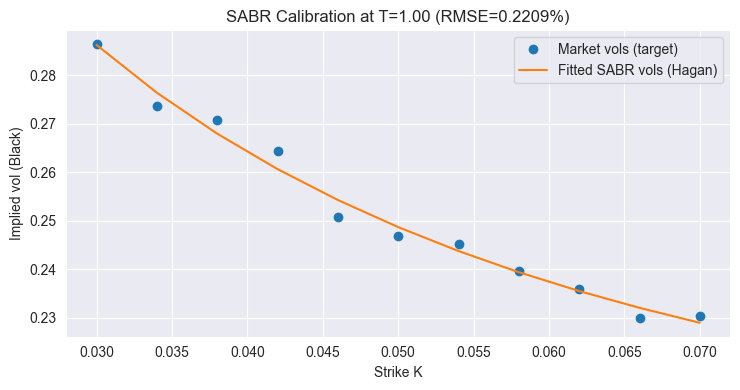

In [ ]:

# ----------------------------------------------------
# 1. Synthetic market data
# ----------------------------------------------------

# generate synthetic market vols from known SABR params
vols_market = np.array([hagan_sabr_iv(F0, K, T1, nu, beta, rho, alpha) for K in Ks])
# Add a little random noise to mimic market data realism
rng = np.random.default_rng(42)
vols_market = vols_market * (1 + 0.01 * rng.standard_normal(len(vols_market)))

# ----------------------------------------------------
# 2. SABR calibration objective
# ----------------------------------------------------
def sabr_error(params, F, K, T, target_vols):
    alpha_, nu_, rho_, beta_ = params
    # enforce parameter bounds for numerical stability
    if not (0 < alpha_ < 2 and 0 < nu_ < 2 and -0.999 < rho_ < 0.999 and 0 < beta_ <= 1):
        return 1e6
    model_vols = np.array([hagan_sabr_iv(F, k, T, nu_, beta_, rho_, alpha_) for k in K])
    return np.sqrt(np.mean((model_vols - target_vols) ** 2))

# ----------------------------------------------------
# 3. Initial guess and optimization
# ----------------------------------------------------

#playing with the real params for an initial guess

x0 = [
    alpha * 0.7,      
    nu * 1.5,         
    rho * 0.5,        
    0.7               
]
res = minimize(sabr_error, x0, args=(F0, Ks, T1, vols_market),
               bounds=[(1e-4, 2.0), (1e-4, 2.0), (-0.999, 0.999), (0.1, 1.0)],
               method='L-BFGS-B')

alpha_fit, nu_fit, rho_fit, beta_fit = res.x
rmse = res.fun

print("=== SABR Calibration Results ===")
print(f"alpha (vol level):     {alpha_fit:.4f}")
print(f"nu (vol of vol):        {nu_fit:.4f}")
print(f"rho (correlation):      {rho_fit:.4f}")
print(f"beta (elasticity):      {beta_fit:.4f}")
print(f"RMSE (implied vols):    {rmse:.6f}")

# ----------------------------------------------------
# 4. Compare fitted vs market vols
# ----------------------------------------------------
vols_fitted = np.array([hagan_sabr_iv(F0, K, T1, nu_fit, beta_fit, rho_fit, alpha_fit) for K in Ks])

plt.figure(figsize=(7.5, 4))
plt.plot(Ks, vols_market, "o", label="Market vols (target)")
plt.plot(Ks, vols_fitted, "-", label="Fitted SABR vols (Hagan)")
plt.xlabel("Strike K")
plt.ylabel("Implied vol (Black)")
plt.title(f"SABR Calibration at T={T1:.2f} (RMSE={rmse:.4%})")
plt.legend()
plt.tight_layout()
plt.show()


### Cross-Model Validation — Calibrating SABR to Heston Data

To test SABR’s robustness, we generate synthetic “market” volatilities from the **Heston model**  
and then fit SABR parameters to this Heston-implied smile.

---

#### Heston Market Generator

The Heston dynamics are:

$$
\begin{aligned}
dF_t &= \sqrt{v_t}\,F_t\,dW_t, \\
dv_t &= \kappa(\theta - v_t)\,dt + \xi\sqrt{v_t}\,dZ_t, \\
\mathrm{Corr}(dW_t,dZ_t) &= \rho.
\end{aligned}
$$

Here $v_t$ is the instantaneous variance,  
$\kappa$ the mean-reversion speed, $\theta$ the long-run variance,  
$\xi$ the volatility of variance, and $\rho$ the correlation.

Simulated paths of $(F_t, v_t)$ give caplet payoffs,  
which are inverted via Black-76 to obtain **Heston-implied vols** $\sigma_{\text{mkt}}(K)$.

---

#### SABR Fit to Heston Smile

We then minimize the RMSE between the **Hagan SABR vols** and the **Heston-implied vols**:

$$
\min_{\alpha,\nu,\rho,\beta}
\sqrt{\frac{1}{N}\sum_i
\bigl[\sigma_{\text{Hagan}}(F_0,K_i,T;\alpha,\nu,\rho,\beta)
-\sigma_{\text{mkt}}(K_i)\bigr]^2 }.
$$

A small RMSE shows that SABR can effectively reproduce a Heston-generated volatility smile.


=== SABR Calibration to Heston Market Data ===
alpha (vol level):     0.0258
nu (vol of vol):        0.4941
rho (correlation):      -0.3728
beta (elasticity):      0.3345
RMSE (implied vols):    0.002391


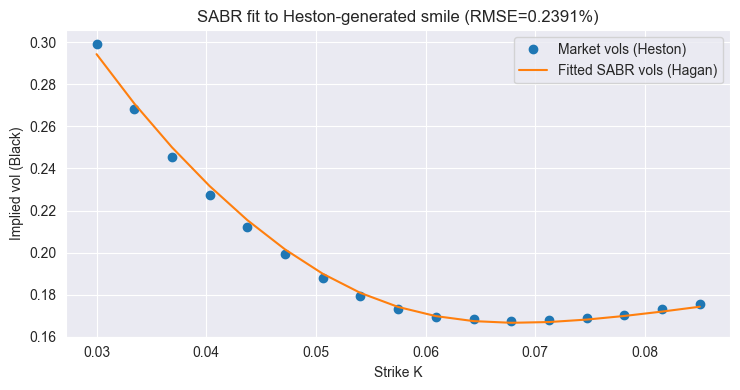

In [46]:
# ----------------------------------------------------
# 1. Heston model simulation to generate "market" data
# ----------------------------------------------------
def simulate_heston(F0, v0, kappa, theta, xi, rho, T, n_steps, n_paths):
    dt = T / n_steps
    F = np.full((n_paths, n_steps + 1), F0)
    v = np.full((n_paths, n_steps + 1), v0)
    for t in range(n_steps):
        Z1 = np.random.normal(size=n_paths)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_paths)
        v[:, t+1] = np.maximum(v[:, t] + kappa*(theta - v[:, t])*dt + xi*np.sqrt(np.maximum(v[:, t],0)*dt)*Z1, 0)
        F[:, t+1] = F[:, t] * np.exp(-0.5*v[:, t]*dt + np.sqrt(v[:, t]*dt)*Z2)
    return F, v

# Heston parameters (market generator)
F0 = float(f[0, 0])
T1 = t
tau = 0.25
r = 0.02
P_T2 = np.exp(-r * (T1 + tau))

heston_params = dict(
    v0=0.04,      # initial variance (20% vol)
    kappa=1.5,    # mean reversion speed
    theta=0.04,   # long-term variance
    xi=0.35,      # vol of vol
    rho=-0.5      # correlation
)

n_steps = 500
n_paths = 20000
paths_heston, var_heston = simulate_heston(F0, **heston_params, T=T1, n_steps=n_steps, n_paths=n_paths)

# Compute Heston "market" prices per strike
F_T = paths_heston[:, -1]
prices_heston = []
for K in Ks:
    payoff = tau * np.maximum(F_T - K, 0)
    prices_heston.append(P_T2 * payoff.mean())
prices_heston = np.array(prices_heston)

# Convert to implied vols (market smile)
vols_market = np.array([
    implied_vol_black_caplet(p, P_T2, F0, K, T1, tau) for p, K in zip(prices_heston, Ks)
])

# ----------------------------------------------------
# 2. Calibrate SABR to these Heston-implied vols
# ----------------------------------------------------
def sabr_error(params, F, K, T, target_vols):
    alpha_, nu_, rho_, beta_ = params
    if not (0 < alpha_ < 2 and 0 < nu_ < 2 and -0.999 < rho_ < 0.999 and 0 < beta_ <= 1):
        return 1e6
    model_vols = np.array([hagan_sabr_iv(F, k, T, nu_, beta_, rho_, alpha_) for k in K])
    return np.sqrt(np.mean((model_vols - target_vols)**2))

# General initial guess (not tuned to anything)
x0 = [0.2 * (F0**(1 - 0.5)), 0.3, -0.2, 0.5]  # alpha, nu, rho, beta

from scipy.optimize import minimize
res = minimize(
    sabr_error,
    x0,
    args=(F0, Ks, T1, vols_market),
    bounds=[(1e-4, 2.0), (1e-4, 2.0), (-0.999, 0.999), (0.1, 1.0)],
    method="L-BFGS-B"
)

alpha_fit, nu_fit, rho_fit, beta_fit = res.x
rmse = res.fun

print("=== SABR Calibration to Heston Market Data ===")
print(f"alpha (vol level):     {alpha_fit:.4f}")
print(f"nu (vol of vol):        {nu_fit:.4f}")
print(f"rho (correlation):      {rho_fit:.4f}")
print(f"beta (elasticity):      {beta_fit:.4f}")
print(f"RMSE (implied vols):    {rmse:.6f}")

# Compare fitted vs Heston vols
vols_fitted = np.array([hagan_sabr_iv(F0, K, T1, nu_fit, beta_fit, rho_fit, alpha_fit) for K in Ks])

plt.figure(figsize=(7.5, 4))
plt.plot(Ks, vols_market, "o", label="Market vols (Heston)")
plt.plot(Ks, vols_fitted, "-", label="Fitted SABR vols (Hagan)")
plt.xlabel("Strike K")
plt.ylabel("Implied vol (Black)")
plt.title(f"SABR fit to Heston-generated smile (RMSE={rmse:.4%})")
plt.legend()
plt.tight_layout()
plt.show()
